In [34]:
#! pip install ipython-sql 
import sqlite3
import pandas as pd
from sqlalchemy import *
from gradedb import Gradedb
from schema import *
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
%load_ext sql
%sql sqlite:///gradedb.db
engine = create_engine("sqlite:///gradedb.db")

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [36]:

Task_summ = text(''' SELECT 
    tk.title AS 'Assignment',
    stu.universityid,
    stu.name AS 'Student Name',
    stu.email AS 'Student Email',
    qu.title AS 'Question Title',
    qu.content AS 'Question Content',
    an.content AS 'Answer Content',
    sc.value AS 'Score on Task'
  FROM Task tk
  LEFT JOIN Assignment asg ON asg.taskid = tk.taskid
  LEFT JOIN Student stu ON stu.universityid = asg.universityid
  LEFT JOIN Task_question tq ON tq.taskid = asg.taskid
  LEFT JOIN Question qu ON qu.questionid = tq.questionid
  LEFT JOIN Answers an ON an.questionid = tq.questionid
  LEFT JOIN Submission sb ON sb.assignmentid = asg.assignmentid
  LEFT JOIN EvaluationRequest er ON er.submissionid = sb.submissionid
  LEFT JOIN Evaluation ev ON ev.requestid = er.requestid
  LEFT JOIN EvaluationFinished ef ON ef.evaluationid = ev.evaluationid
  LEFT JOIN Scores sc ON sc.evaluationid = ev.evaluationid;
  ''')

In [37]:
df_Task_summ = pd.read_sql(Task_summ, engine)           # dataframe for task summary

In [38]:
# function for information about the individual tasks 
def task_summaryDF(Task):
    teacher_summary = (df_Task_summ[df_Task_summ['Assignment']== Task])                                                  # filter for specific task
    df_teacher_sum = teacher_summary.drop_duplicates(subset=['Assignment','universityid','Question Title'], keep='last') # show only latest submitted question answer
    return(df_teacher_sum)

In [39]:
Teacher_summ = text(''' SELECT 
    tk.title AS 'Assignment',
    stu.universityid AS 'Students',
    qu.title AS 'Questions',
    an.content AS 'Answers',
    sc.value AS 'Grades given'
  FROM Task tk
  LEFT JOIN Assignment asg ON asg.taskid = tk.taskid
  LEFT JOIN Student stu ON stu.universityid = asg.universityid
  LEFT JOIN Task_question tq ON tq.taskid = asg.taskid
  LEFT JOIN Question qu ON qu.questionid = tq.questionid
  LEFT JOIN Answers an ON an.questionid = tq.questionid
  LEFT JOIN Submission sb ON sb.assignmentid = asg.assignmentid
  LEFT JOIN EvaluationRequest er ON er.submissionid = sb.submissionid
  LEFT JOIN Evaluation ev ON ev.requestid = er.requestid
  LEFT JOIN EvaluationFinished ef ON ef.evaluationid = ev.evaluationid
  LEFT JOIN Scores sc ON sc.evaluationid = ev.evaluationid;
  ''')

In [40]:
df_Teacher_summ = pd.read_sql(Teacher_summ, engine) # dataframe for teacher summary and grade summary

In [41]:
# function for information about the tasks for teacher 
def teacher_summaryDF():
    df_teacher_sum3 = df_Teacher_summ.drop_duplicates(subset=['Assignment','Students'], keep='last')                # show only last handed in answer for specific task and specific student
    Ass_id_grades = df_teacher_sum3.groupby('Assignment').count()[['Students', 'Grades given']]                     # create dataframe with specific imformation about students and grades for specific task
    df_teacher_sum2 = df_Teacher_summ.drop_duplicates(subset=['Assignment','Students','Questions'], keep='last')    # show only last handed in answer for specific question, specific student and specific task
    Ass_question_answer = df_teacher_sum2.groupby('Assignment').count()[['Questions', 'Answers']]                   # create dataframe with the given questions and answers for tasks
    Ass_question_answer['Unanswered questions'] = Ass_question_answer['Questions'] - Ass_question_answer['Answers'] # add to question/answer dataframe the amount of unanswered questions
    horizontal_stack = pd.concat([Ass_question_answer, Ass_id_grades], axis=1)                                      # combine dataframes made above
    horizontal_stack['Missing Grades'] = horizontal_stack['Students'] - horizontal_stack['Grades given']            # add the amount of missing grades to dataframe
    return(horizontal_stack)

In [42]:
# function for grades information for tasks 
def grades_summaryDF():
    df_teacher_sum4 = df_Teacher_summ.drop_duplicates(subset=['Assignment','Students'], keep='last')   # show only last handed in answer for specific task and specific student
    df_teacher_sum5 = df_teacher_sum4[['Assignment','Grades given']]                                      # create dataframe with specific imformation about grades for specific task
    df_teacher_sum5 = df_teacher_sum5.sort_values(by=['Assignment'])                                      # sort by tasks
    plt.figure(figsize=(12,4))                                                                            # create a plot of specific size
    sns.stripplot(x=df_teacher_sum5['Assignment'], y=df_teacher_sum5['Grades given'],hue=df_teacher_sum5['Assignment'])  # create stripplot for visual image of grades distribution 
    plt.title('Received grades for tasks')
    plt.ylim(0, 10)
    plt.show()
    return(df_teacher_sum5)

In [43]:
# the output for the summary of the different tasks
task_summaryDF('Task 688')

,Assignment,universityid,Student Name,Student Email,Question Title,Question Content,Answer Content,Score on Task
3,Task 688,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 1,Over customhouses toddy spacious depleters asi...,To calculate intuitions Dikê creamed Ireland f...,5.0
7,Task 688,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 2,Calculate puffkin artless gimping criminalist ...,Resulting in reoccupied reforming pinky cajupu...,5.0
9,Task 688,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 5,Over unpossessed Uke merulius haunch kindled?,Resulting in turnip-radish Neosho River dispar...,5.0
13,Task 688,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 1,Over customhouses toddy spacious depleters asi...,To calculate intuitions Dikê creamed Ireland f...,1.0
17,Task 688,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 2,Calculate puffkin artless gimping criminalist ...,Resulting in reoccupied reforming pinky cajupu...,1.0
19,Task 688,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 5,Over unpossessed Uke merulius haunch kindled?,Resulting in turnip-radish Neosho River dispar...,1.0
23,Task 688,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 1,Over customhouses toddy spacious depleters asi...,To calculate intuitions Dikê creamed Ireland f...,9.0
27,Task 688,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 2,Calculate puffkin artless gimping criminalist ...,Resulting in reoccupied reforming pinky cajupu...,9.0
29,Task 688,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 5,Over unpossessed Uke merulius haunch kindled?,Resulting in turnip-radish Neosho River dispar...,9.0
33,Task 688,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 1,Over customhouses toddy spacious depleters asi...,To calculate intuitions Dikê creamed Ireland f...,1.0


In [44]:
# the output for the teacher summary
teacher_summaryDF()

,Questions,Answers,Unanswered questions,Students,Grades given,Missing Grades
Assignment,,,,,,
Task 405,6,6,0,2,1,1
Task 688,12,12,0,4,4,0
Task 871,12,12,0,4,3,1
Task 913,9,6,3,3,2,1
Task 980,6,4,2,2,1,1


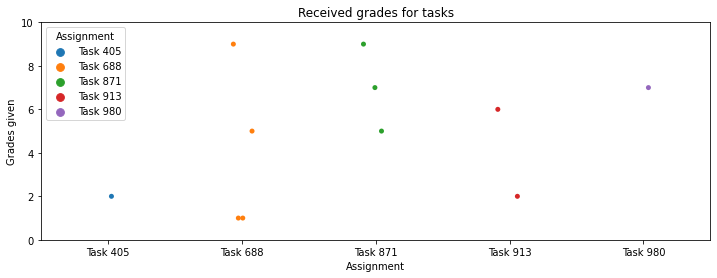

,Assignment,Grades given
43,Task 405,NaN
47,Task 405,2.0
9,Task 688,5.0
19,Task 688,1.0
29,Task 688,9.0
39,Task 688,1.0
57,Task 871,9.0
67,Task 871,5.0
77,Task 871,7.0
87,Task 871,NaN


In [45]:
# the output for the summary of the recieved grades
grades_summaryDF()
